# Garmin Analysis Notebook:

## Modules and Data Import:

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import plotly.graph_objects as go

# import OLS
import statsmodels.api as sm
from statsmodels.formula.api import ols

import calendar

plt.style.use('ggplot')

# dont show errors
import warnings
warnings.filterwarnings('ignore')


In [33]:
from Garmin_API_V1 import activitydata

In [34]:
activitydata['date'] = pd.to_datetime(activitydata['date']).dt.date

activitydata = activitydata.assign(
    year=pd.DatetimeIndex(activitydata['date']).year,
    month=pd.DatetimeIndex(activitydata['date']).month
).query('pace > 0').query(
    'activityType == "running" or activityType == "trail_running" or activityType == "treadmill_running"'
)

# if elevationGain is null, set it to 0
activitydata['elevationGain'] = activitydata['elevationGain'].fillna(0)


In [35]:

monthly = ( activitydata[(activitydata['year'] >= 2023)]
           .groupby(['year', 'month'])['distance']
           .sum()
           .reset_index()
)
# monthly.head(20)


## Analysis

### Monthly Progres:

#### Graphs:

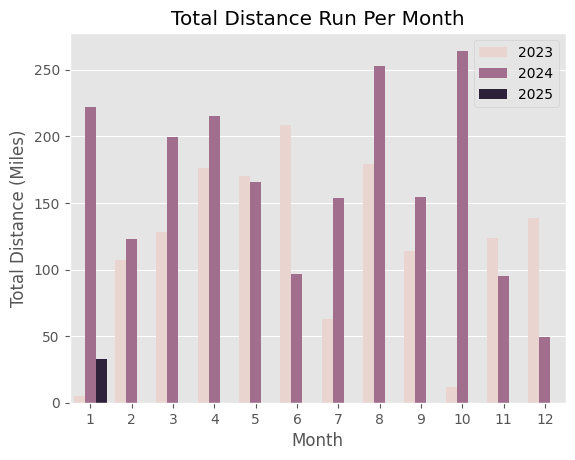

In [36]:
p = sns.barplot(x=monthly.month, y='distance', data=monthly, hue='year')
plt.ylabel('Total Distance (Miles)')
plt.xlabel('Month')
plt.legend(loc='upper right')  
plt.title('Total Distance Run Per Month')
plt.show()


In [37]:
base_zone = (activitydata[(activitydata['year'] >= 2024) & 
                         (activitydata['averageHR'] >= 140) & 
                         (activitydata['averageHR'] < 150)]
            .assign(quarter=lambda x: pd.DatetimeIndex(x['date']).quarter)
            .query('~activityName.str.contains("Intervals")')
            .query('~activityName.str.contains("Hybrid")')
            .query('~activityName.str.contains("Hike")')
            .query('activityType != "trail_running"')
            .query('date != @dt.date(2024, 8, 31)')
            # query when activity is not treadmill and ascent is not greater than 100
            .query('elevationGain < 1000')

            )


In [38]:
easy_zone = (activitydata[(activitydata['year'] >= 2024) & 
                         (activitydata['averageHR'] >= 120) & 
                         (activitydata['averageHR'] < 140)]
            .assign(quarter=lambda x: pd.DatetimeIndex(x['date']).quarter)
            .query('~activityName.str.contains("Intervals")')
            .query('~activityName.str.contains("Hybrid")')
            .query('~activityName.str.contains("Hike")')
            .query('activityType != "trail_running"')
            .query('date != @dt.date(2024, 8, 31)')
            .query('date != @dt.date(2024, 2, 28)')
            .query('elevationGain < 1000')
)




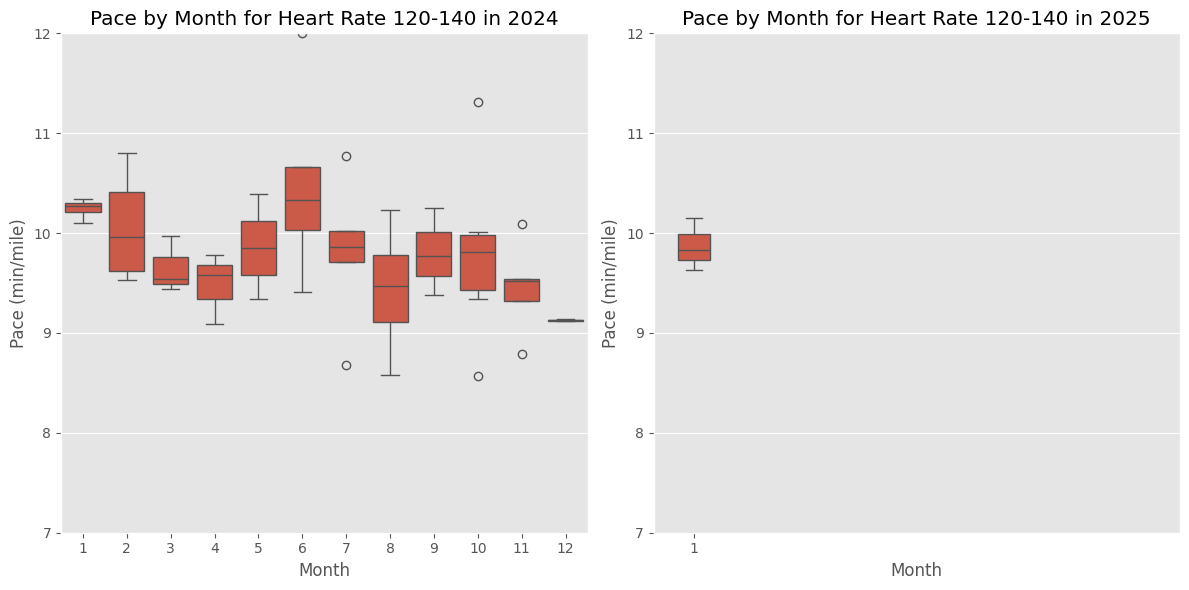

In [39]:
# Filter data for 2024 and 2025
easy_zone_2024 = easy_zone[easy_zone['year'] == 2024]
easy_zone_2025 = easy_zone[easy_zone['year'] == 2025]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot of pace for each month in 2024
sns.boxplot(x='month', y='pace', data=easy_zone_2024, ax=axes[0])
axes[0].set_ylabel('Pace (min/mile)')
axes[0].set_xlabel('Month')
axes[0].set_ylim(7, 12)
axes[0].set_title('Pace by Month for Heart Rate 120-140 in 2024')

# Boxplot of pace for each month in 2025
sns.boxplot(x='month', y='pace', data=easy_zone_2025, ax=axes[1])
axes[1].set_ylabel('Pace (min/mile)')
axes[1].set_xlabel('Month')
axes[1].set_xlim(-1, 12)
axes[1].set_ylim(7, 12)
axes[1].set_title('Pace by Month for Heart Rate 120-140 in 2025')

plt.tight_layout()
plt.show()


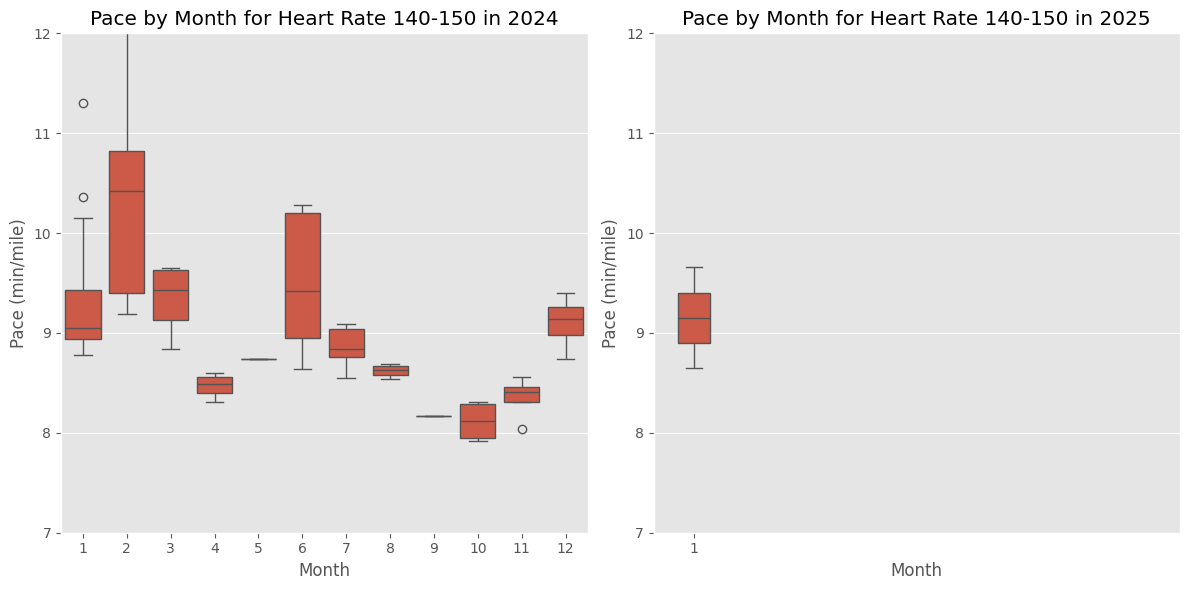

In [40]:
# Filter data for 2024 and 2025
base_zone_2024 = base_zone[base_zone['year'] == 2024]
base_zone_2025 = base_zone[base_zone['year'] == 2025]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot of pace for each month in 2024
sns.boxplot(x='month', y='pace', data=base_zone_2024, ax=axes[0])
axes[0].set_ylabel('Pace (min/mile)')
axes[0].set_xlabel('Month')
axes[0].set_ylim(7, 12)
axes[0].set_title('Pace by Month for Heart Rate 140-150 in 2024')

# Boxplot of pace for each month in 2025
sns.boxplot(x='month', y='pace', data=base_zone_2025, ax=axes[1])
axes[1].set_ylabel('Pace (min/mile)')
axes[1].set_xlabel('Month')
axes[1].set_xlim(-1, 12)
axes[1].set_ylim(7, 12)
axes[1].set_title('Pace by Month for Heart Rate 140-150 in 2025')

plt.tight_layout()
plt.show()


In [41]:
# Calculate the rolling means
rolling_mean_base_pace = base_zone['pace'].rolling(window=3).mean()
rolling_mean_easy_zone = easy_zone['pace'].rolling(window=3).mean()

# Create the figure
fig = go.Figure()

# Scatter plot for `base_zone`
fig.add_trace(go.Scatter(
    x=base_zone['date'],
    y=base_zone['pace'],
    mode='markers',
    marker=dict(opacity=0.5, color='orange'),
    name='Pace (Base HR 140-150)'
))

# Rolling mean for `base_zone`
fig.add_trace(go.Scatter(
    x=base_zone['date'],
    y=rolling_mean_base_pace,
    mode='lines',
    line=dict(color='orange'),
    name='Rolling Mean (Base HR 140-150)'
))

# Scatter plot for `easy_zone`
fig.add_trace(go.Scatter(
    x=easy_zone['date'],
    y=easy_zone['pace'],
    mode='markers',
    marker=dict(opacity=0.5, color='blue'),
    name='Pace (Easy HR 110-140)'
))

# Rolling mean for `easy_zone`
fig.add_trace(go.Scatter(
    x=easy_zone['date'],
    y=rolling_mean_easy_zone,
    mode='lines',
    line=dict(color='blue'),
    name='Rolling Mean (Easy HR 110-140)'
))

# Define vertical lines with annotations with text offset from the line
vlines = [
    {'date': pd.Timestamp('2024-02-01'), 'label': 'Covid', 'xshift': 5},
    {'date': pd.Timestamp('2024-05-08'), 'label': 'Sedona Canyons 125', 'xshift': 5},
    {'date': pd.Timestamp('2024-10-26'), 'label': 'Ozark Trail 100', 'xshift': 5}
]

# Add vertical lines and annotations
for vline in vlines:
    fig.add_vline(
        x=vline['date'],
        line=dict(color='red', dash='dash')
    )
    fig.add_annotation(
        x=vline['date'],
        y=12,  # Adjust y-position based on the plot range
        text=vline['label'],
        showarrow=False,
        yshift=10,
        textangle=90,
        font=dict(size=12)
    )

# Update layout
fig.update_layout(
    width=800,
    height=500,
    title='Combined Pace Over Time for HR Zones (Base HR 140-150 and Easy HR 110-140)',
    xaxis_title='Date',
    yaxis_title='Pace (min/mile)',
    xaxis=dict(tickangle=45),
    showlegend=True
)

# Display the figure
fig.show()

In [42]:
easy_zone_monthly = (easy_zone
                    .groupby(['year', 'month'])['pace']
                    .mean()
                    .reset_index()
)

base_zone_monthly = (base_zone
                     .groupby(['year', 'month'])['pace']
                     .mean()
                     .reset_index()
)

easy_base_compare = ( pd.merge(easy_zone_monthly, base_zone_monthly, on=['year', 'month'], suffixes=('_easy', '_base'))
                        .assign(pace_diff=lambda x: x['pace_easy'] - x['pace_base'])
    )


In [43]:
easy_base_compare.head(20)

,year,month,pace_easy,pace_base,pace_diff
0,2024,1,10.244291,9.346025,0.898266
1,2024,2,10.066142,10.415537,-0.349395
2,2024,3,9.652199,9.336578,0.315621
3,2024,4,9.486196,8.473536,1.012660
4,2024,5,9.857359,8.738529,1.118830
5,2024,6,10.487210,9.484373,1.002837
6,2024,7,9.810667,8.856115,0.954552
7,2024,8,9.437113,8.620558,0.816555
8,2024,9,9.799560,8.166994,1.632566
9,2024,10,9.806063,8.116913,1.689150
